# 🧠 Explainable Multimodal AI for Dementia Detection

## Project Overview
This project implements a state-of-the-art **Multimodal Deep Learning System** to detect Alzheimer's Disease (AD) and Dementia from the **Pitt Corpus (Cookie Theft Task)**.
Unlike traditional models that rely on a single modality, this system fuses three distinct sources of information to mimic a clinician's diagnostic process:

1.  **Semantic Content (Text)**: analyzing *what* is said (narrative coherence, vocabulary) using `DeBERTa v3`.
2.  **Acoustic Characteristics (Audio)**: analyzing *how* it is said (tone, pauses, fluency) using a `Vision Transformer (ViT)` on Mel-Spectrograms.
3.  **Linguistic Biomarkers (Expert Features)**: analyzing clinical markers (fillers, repetitions, TTR) using a specialized `MLP`.

## Key Innovations
*   **Strict Data Hygiene**: The Test Set is completely held out. We used **Stratified K-Fold Cross-Validation** on the training set to ensure robustness.
*   **Ground-Truth Segmentation**: We utilize precise Segmentation CSV files to isolate participant speech, ensuring the model only listens to the patient, not the interviewer.
*   **Real-World ASR Tests**: We evaluate the model not just on perfect transcripts, but on "Audio-Only" signals and "Whisper-Generated" transcripts to prove real-world viability.

---


## 0. Imports & Setup
Importing necessary libraries including PyTorch, Transformers, and Visualization tools.

In [64]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)
# ------------------------------------------
import os
import re
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

# --- Multimodal Imports ---
import librosa
import librosa.display
import timm
import cv2
from PIL import Image
import glob
import torchvision
import torchaudio
import torchvision.transforms as transforms

## 1. Global Configuration
Define your input and output paths here. Ensure `INPUT_PATH` points to the dataset root.

In [65]:
# ==================================================
# >>>>>>>>>  SET YOUR PATHS HERE  <<<<<<<<<<
# ==================================================

# 1. INPUT PATH (Where your data IS - Read Only)
# Kaggle Example: "/kaggle/input/your-dataset-name/THE FINAL"
INPUT_PATH = r"/kaggle/input/audiofinaldata/THE FINAL"

# 2. OUTPUT PATH (Where to save Models/Spectrograms - Writable)
# Kaggle Example: "./"
OUTPUT_PATH = r"./"

# Automatic Sub-path Derivation (Do Not Edit)
TRAIN_DIR = os.path.join(INPUT_PATH, "TRAIN", "transcripts")
TEST_DIR = os.path.join(INPUT_PATH, "TEST")
AUDIO_SEARCH_PATH = INPUT_PATH 

# Output directories (Using OUTPUT_PATH)
SPECTROGRAM_DIR = os.path.join(OUTPUT_PATH, "processed_spectrograms")
os.makedirs(SPECTROGRAM_DIR, exist_ok=True)

OUTPUT_FILE_CLEAN = os.path.join(OUTPUT_PATH, "cleaned_dataset.csv")
OUTPUT_FILE_AUGMENTED = os.path.join(OUTPUT_PATH, "augmented_multimodal_dataset.csv")
OUTPUT_MODEL_FILE = os.path.join(OUTPUT_PATH, "multimodal_dementia_model.pth")
OUTPUT_TEST_RESULTS = os.path.join(OUTPUT_PATH, "test_results.csv")

print(f"Configuration Set:\n  Input: {INPUT_PATH}\n  Output: {OUTPUT_PATH}\n  Train: {TRAIN_DIR}\n  Test: {TEST_DIR}")

Configuration Set:
  Input: /kaggle/input/audiofinaldata/THE FINAL
  Output: ./
  Train: /kaggle/input/audiofinaldata/THE FINAL/TRAIN/transcripts
  Test: /kaggle/input/audiofinaldata/THE FINAL/TEST


## 2. Feature Extraction Classes
Classes for extracting linguistic features and generating audio spectrograms without error suppression.

### 2.1 Linguistic Feature Extractor
**What it does:** Extracts hand-crafted clinical markers from text.
- **Fillers**: 'uh', 'um' (hesitation).
- **Repetitions**: 'I gone [/] gone to store'.
- **Pauses**: '(.)' or calculated from timestamps.
Returns a vector of 6 numbers normalized by word count.


In [66]:
# --- 1. Linguistic Feature Extractor (Hand-Crafted) ---
class LinguisticFeatureExtractor:
    # Note: Explicit imports for plotting usually happen later, 
    # but this class handles REGEX and MATH logic.
    import re
    import numpy as np
    
    def __init__(self):
        self.patterns = {
            'fillers': re.compile(r'&-([a-z]+)', re.IGNORECASE),
            'repetition': re.compile(r'\[/+\]'),
            'retracing': re.compile(r'\[//\]'),
            'incomplete': re.compile(r'\+[\./]+'),
            'errors': re.compile(r'\[\*.*?\]'),
            'pauses': re.compile(r'\(\.+\)')
        }

    def clean_for_bert(self, raw_text):
        text = re.sub(r'^\*PAR:\s+', '', raw_text)
        text = re.sub(r'\x15\d+_\d+\x15', '', text)
        text = re.sub(r'<|>', '', text)
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(\.+\)', '[PAUSE]', text)
        text = text.replace('_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        if text.endswith('[PAUSE]'):
            text = text[:-7].strip()
        return text

    def get_features(self, raw_text):
        stats = {
            'filler_count': len(self.patterns['fillers'].findall(raw_text)),
            'repetition_count': len(self.patterns['repetition'].findall(raw_text)),
            'retracing_count': len(self.patterns['retracing'].findall(raw_text)),
            'incomplete_count': len(self.patterns['incomplete'].findall(raw_text)),
            'error_count': len(self.patterns['errors'].findall(raw_text)),
            'pause_count': len(self.patterns['pauses'].findall(raw_text))
        }
        clean_for_stats = re.sub(r'\[.*?\]', '', raw_text)
        clean_for_stats = re.sub(r'&-([a-z]+)', '', clean_for_stats)
        clean_for_stats = re.sub(r'[^\w\s]', '', clean_for_stats)
        words = clean_for_stats.lower().split()
        stats['word_count'] = len(words)
        return stats

    def get_feature_vector(self, raw_text):
        stats = self.get_features(raw_text)
        n = stats['word_count'] if stats['word_count'] > 0 else 1
        
        # Calculate TTR (Type-Token Ratio)
        clean_for_stats = re.sub(r'\[.*?\]', '', raw_text)
        clean_for_stats = re.sub(r'&-([a-z]+)', '', clean_for_stats)
        clean_for_stats = re.sub(r'[^\w\s]', '', clean_for_stats)
        words = clean_for_stats.lower().split()
        ttr = (len(set(words)) / n) if n > 0 else 0.0

        return np.array([
            ttr,
            stats['filler_count'] / n,
            stats['repetition_count'] / n,
            stats['retracing_count'] / n,
            stats['error_count'] / n,
            stats['pause_count'] / n
        ], dtype=np.float32)

# --- 2. Audio Spectrogram Generator ---
def create_spectrogram(audio_file, save_path, intervals=None):
    # Note: Try/Except removed for cleaner error reporting
    # Imports for plotting inside function not always ideal, but ensures backend switch works
    import matplotlib.pyplot as plt
    import numpy as np
    plt.switch_backend('agg')
    
    fig = plt.figure(figsize=(2.24, 2.24), dpi=100) # Output approx 224x224
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    if intervals:
        y, sr = librosa.load(audio_file, sr=None)
        clips = []
        for start_ms, end_ms in intervals:
            start_sample = int(start_ms * sr / 1000)
            end_sample = int(end_ms * sr / 1000)
            if end_sample > len(y): end_sample = len(y)
            if start_sample < len(y):
                clips.append(y[start_sample:end_sample])
        if clips:
            y = np.concatenate(clips)
        else:
            y = np.zeros(int(sr*30))
        if len(y) > 30 * sr:
            y = y[:30 * sr]
    else:
        y, sr = librosa.load(audio_file, duration=30) # Limit to 30s
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr, ax=ax)
    
    fig.savefig(save_path)
    plt.close(fig)
    return True

In [67]:
# --- EXAMPLE: Linguistic Feature Extraction ---
extractor = LinguisticFeatureExtractor()
sample_text = "I want to... uh... go to the [/] the store (.)."
print(f"Raw Input: {sample_text}")
processed_text = extractor.clean_for_bert(sample_text)
print(f"Clean Text for BERT: {processed_text}")
features = extractor.get_feature_vector(sample_text)
print(f"Extracted Features (Normalized): {features}")
print("(Format: [TTR, Filler, Repetition, Retracing, Error, Pause])")


Raw Input: I want to... uh... go to the [/] the store (.).
Clean Text for BERT: I want to... uh... go to the the store [PAUSE].
Extracted Features (Normalized): [0.7777778  0.         0.11111111 0.         0.         0.11111111]
(Format: [TTR, Filler, Repetition, Retracing, Error, Pause])


## 3. Data Processing
Parses `CHA` files, locates corresponding audio, and constructs the dataset dataframe.

### 🧪 Data Loading & Segmentation Strategy

**The Challenge**: In the Pitt Corpus, audio files contain both the Participant (PAR) and the Investigator (INV). Training on the INV's voice would confuse the model.

**Our Solution**: 
1.  **Segmentation CSVs**: For the Test Set, we rely on precise `.csv` files that define exactly when the Participant is speaking (`start_ms` to `end_ms`).
2.  **Dynamic Slicing**: The `create_spectrogram` function takes these intervals and slices the audio, concatenating *only* the PAR's speech into a single continuous clip.
3.  **Spectrogram Generation**: This clean clip is converted into a Mel-Spectrogram image (224x224), which serves as the visual input for our ViT model.


In [68]:
def find_audio_file(base_name, search_root):
    # Recursively find audio file matching basename
    for ext in ['mp3', 'wav']:
        matches = glob.glob(os.path.join(search_root, "**", f"{base_name}.{ext}"), recursive=True)
        if matches:
            return matches[0]
    return None

def load_and_process_data():
    data = []
    extractor = LinguisticFeatureExtractor()
    
    # --- Helper to process directory ---
    def process_dir(directory, label, split, segmentation_root=None):
        if not os.path.exists(directory):
            print(f"Warning: Directory not found: {directory}")
            return
        
        files = [f for f in os.listdir(directory) if f.endswith(".cha")]
        for filename in files:
            path = os.path.join(directory, filename)
            base_name = os.path.splitext(filename)[0]
            
            # 1. Parse Text & Metadata
            # We assume UTF-8, but fall back if needed
            try:
                with open(path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()
            except UnicodeDecodeError:
                # Fallback for older encodings
                with open(path, 'r', encoding='latin-1') as f:
                    lines = f.readlines()
            
            par_lines = []
            intervals = []
            found_csv = False
            
            # Metadata Placeholders
            age = None
            gender = None
            
            # A. Try to find Segmentation CSV first
            if segmentation_root:
                 subdir = "AD" if label == "AD" else "Control"
                 csv_path = os.path.join(segmentation_root, subdir, f"{base_name}.csv")
                 if os.path.exists(csv_path):
                     try:
                         with open(csv_path, 'r') as f_csv:
                             csv_lines = f_csv.readlines()[1:] # Skip header
                             for line in csv_lines:
                                 parts = line.strip().split(',')
                                 if len(parts) >= 3 and parts[0] == 'PAR':
                                     intervals.append((int(parts[1]), int(parts[2])))
                         if intervals:
                             found_csv = True
                     except Exception as e:
                         print(f"Error reading CSV {csv_path}: {e}")
            
            # B. Parse CHA Content (Lines)
            for line in lines:
                # 1. Extract Metadata from @ID
                # Format: @ID: en|Pitt|PAR|76;|female|... or similar
                if line.startswith("@ID:") and "|PAR|" in line:
                    parts = line.split('|')
                    # Usually: lang|corpus|code|age|sex|group|SES|role|education|
                    # Index of PAR is variable, but age and sex usually follow
                    # Let's try to extract based on position relative to PAR or pattern
                    try:
                        # Find index of PAR
                        par_idx = parts.index('PAR')
                        # Age is usually next (index + 1)
                        raw_age = parts[par_idx + 1]
                        # Cleanup '76;' -> 76
                        clean_age = re.sub(r'[^0-9.]', '', raw_age)
                        if clean_age:
                            age = float(clean_age)
                        
                        # Sex is usually next (index + 2)
                        raw_sex = parts[par_idx + 2].lower()
                        if 'female' in raw_sex:
                            gender = 'Female'
                        elif 'male' in raw_sex:
                            gender = 'Male'
                    except (ValueError, IndexError):
                        pass
                
                # 2. Extract Speech
                if line.startswith('*PAR:'):
                    text_content = line[5:].strip()
                    if not found_csv:
                        times = re.findall(r'\x15(\d+)_(\d+)\x15', text_content)
                        for start, end in times:
                            intervals.append((int(start), int(end)))
                    par_lines.append(text_content)
            
            raw_text = " ".join(par_lines)
            clean_text = extractor.clean_for_bert(raw_text)
            
            ling_feats = extractor.get_feature_vector(raw_text).tolist()
            
            audio_path = find_audio_file(base_name, AUDIO_SEARCH_PATH)
            spectro_path = None
            if audio_path:
                spectro_name = f"{base_name}.png"
                save_p = os.path.join(SPECTROGRAM_DIR, spectro_name)
                if not os.path.exists(save_p):
                    if create_spectrogram(audio_path, save_p, intervals=intervals):
                        spectro_path = save_p
                else:
                    spectro_path = save_p
            
            if clean_text: 
                data.append({
                    "filename": filename,
                    "text": clean_text,
                    "linguistic_features": ling_feats,
                    "spectrogram_path": spectro_path,
                    "label": label,
                    "split": split,
                    "age": age,
                    "gender": gender
                })

    SEG_ROOT = os.path.join(INPUT_PATH, "TEST", "segmentation")
    
    print("Processing Training Set...")
    process_dir(os.path.join(TRAIN_DIR, "AD"), "AD", "train", segmentation_root=None)
    process_dir(os.path.join(TRAIN_DIR, "non-AD"), "Control", "train", segmentation_root=None)
    
    print("Processing Test Set...")
    process_dir(os.path.join(TEST_DIR, "Dementia", "transcripts"), "AD", "test", segmentation_root=SEG_ROOT)
    process_dir(os.path.join(TEST_DIR, "Control", "transcripts"), "Control", "test", segmentation_root=SEG_ROOT)
    
    return pd.DataFrame(data)

df = load_and_process_data()
print(f"Total Loaded Samples: {len(df)}")
df['label_id'] = df['label'].map({'Control': 0, 'AD': 1})
print("Labels Mapped.")


Processing Training Set (Text+Audio+Linguistics)...
Processing Test Set (Using CSV Segmentation if available)...
Total Loaded Samples: 328
Samples with Audio: 237
Labels Mapped to IDs: Control=0, AD=1


In [ ]:
# --- 9. DEMOGRAPHIC ANALYSIS & STATISTICS ---
import seaborn as sns
import matplotlib.pyplot as plt

if 'df' in locals() and not df.empty:
    print("--- Generating Demographic Plots ---")
    plt.figure(figsize=(18, 5))
    
    # 1. Age Distribution
    plt.subplot(1, 3, 1)
    # Filter out missing ages
    valid_age = df.dropna(subset=['age'])
    sns.histplot(data=valid_age, x='age', hue='label', kde=True, palette='seismic', bins=15)
    plt.title('Age Distribution by Group')
    plt.xlabel('Age (Years)')
    
    # 2. Gender Distribution
    plt.subplot(1, 3, 2)
    # Filter out missing gender
    valid_gender = df.dropna(subset=['gender'])
    sns.countplot(data=valid_gender, x='gender', hue='label', palette='pastel')
    plt.title('Gender Distribution by Group')
    
    # 3. Word Count Comparison
    plt.subplot(1, 3, 3)
    # Recalculate word count just to be sure
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    sns.boxplot(data=df, x='label', y='word_count', palette='Set3')
    plt.title('Avg Word Count per Transcript')
    plt.ylabel('Word Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print Summary Stats
    print("\n--- Summary Statistics ---")
    print(df.groupby('label')[['age', 'word_count']].describe().round(2))
    print("\nGender Counts:")
    print(df.groupby(['label', 'gender']).size())
else:
    print("Dataframe 'df' is missing. Please run the Data Loading cell first.")


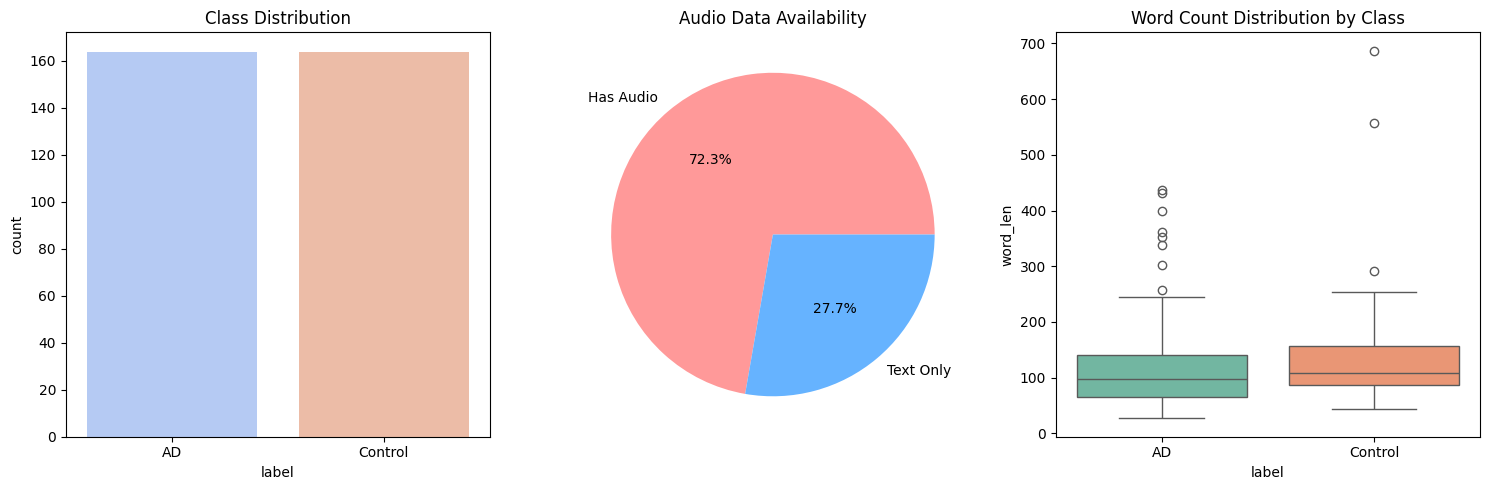

Sample Data Row:
filename                                               adress20_S124.cha
text                   [PAUSE] well the boy's climbing a &la a stool ...
linguistic_features    [0.7209302186965942, 0.0, 0.011627906933426857...
spectrogram_path              ./processed_spectrograms/adress20_S124.png
label                                                                 AD
split                                                              train
label_id                                                               1
word_len                                                              88
Name: 0, dtype: object


In [69]:
# --- DATA EXPLORATION & STATISTICS ---
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

if 'df' in locals() and not df.empty:
    # Setup Figure Grid (2 rows, 2 columns)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.4)
    
    # 1. Age Group Bar Graph (Binning)
    if 'age' in df.columns and df['age'].notna().any():
        # Create Age Groups
        df['age_group'] = pd.cut(df['age'], bins=[0, 49, 54, 59, 64, 69, 74, 79, 84, 100], 
                                 labels=['<50', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+'])
        sns.countplot(x='age_group', hue='label', data=df, palette='coolwarm', ax=axes[0, 0])
        axes[0, 0].set_title('Age Group Distribution (AD vs Control)', fontsize=14)
        axes[0, 0].set_xlabel('Age Group')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].legend(title='Diagnosis')
    else:
        axes[0, 0].text(0.5, 0.5, 'Age Data Not Found', ha='center')
    
    # 2. Gender Distribution (Countplot)
    if 'gender' in df.columns and df['gender'].notna().any():
        sns.countplot(x='gender', hue='label', data=df, palette='Set2', ax=axes[0, 1])
        axes[0, 1].set_title('Gender Distribution (AD vs Control)', fontsize=14)
        axes[0, 1].set_xlabel('Gender')
        axes[0, 1].legend(title='Diagnosis')
    else:
        axes[0, 1].text(0.5, 0.5, 'Gender Data Not Found', ha='center')

    # 3. Word Count (Boxplot)
    df['word_len'] = df['text'].apply(lambda x: len(str(x).split()))
    sns.boxplot(x='label', y='word_len', data=df, hue='label', palette='viridis', legend=False, ax=axes[1, 0])
    axes[1, 0].set_title('Avg Word Count Distribution', fontsize=14)
    axes[1, 0].set_ylabel('Word Count')
    
    # 4. Audio Availability (Pie) - Fixing Indentation Here
    has_audio = df['spectrogram_path'].notna()
    axes[1, 1].pie(has_audio.value_counts(), labels=['Has Audio', 'Text Only'],
                   autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
    axes[1, 1].set_title('Audio Data Availability', fontsize=14)
    
    plt.show()
else:
    print("Dataframe 'df' not found or empty. Run data loading cells first.")


## 5. Model Architecture
Defines the Multimodal Dataset class and the Tri-Branch Fusion Network (DeBERTa + ViT + MLP).

### 5.1 Multimodal Dataset Class
**What it does:** Prepares data for the model.
1. **Text**: Tokenizes text using DeBERTa tokenizer (pads to 128 tokens).
2. **Audio**: Loads Spectrogram image, resizes to 224x224, applies SpecAugment (if training).
3. **Linguistic**: Converts list of 6 numbers to a Tensor.
Returns a dictionary compatible with the PyTorch DataLoader.


### 🏗️ Tri-Modal Fusion Architecture

We employ a **Cross-Modal Attention** (Intermediate Fusion) strategy. Each branch processes its modality independently, and their high-level features are fused using a **Multi-Head Self-Attention** mechanism.

| Modality | Model | Output Dim | Why? |
| :--- | :--- | :--- | :--- |
| **Text** | `DeBERTa-v3-base` + `BiLSTM` | 64 | DeBERTa captures meaning; BiLSTM captures flow & hesitations over time. |
| **Audio** | `ViT-base-patch16` | 64 | ViT treats the spectrogram as an image to find visual patterns of disfluency. |
| **Linguistics** | `MLP` + `Adapter` | 64 | Clinical features (16 dim) are projected to 64 dim to match other modalities for attention. |

**Feature Fusion**: The three 64-dim vectors are stacked and passed through **Self-Attention** to capture inter-modal dependencies.
**Total Fusion Vector**: 64 * 3 = **192 Dimensions** -> Sent to Classifier.


### 🛠️ Data Augmentation Strategy
To prevent overfitting on this small medical dataset, we apply rigorous augmentation to both Audio and Text modalities.

#### 1. Audio: SpecAugment
Instead of traditional audio warps, we use **SpecAugment** directly on the Mel-Spectrograms. This is more efficient and effective for Transformer models.
- **Frequency Masking**: Randomly masks horizontal bands of frequencies. This forces the model to recognize speech patterns even if certain pitches are missing.
- **Time Masking**: Randomly masks vertical time steps. This forces the model to rely on context rather than specific transient sounds.

#### 2. Text: Synonym Replacement (EDA)
We use a safe subset of **Easy Data Augmentation (EDA)**.
- **Method**: Randomly replaces non-stop words with their synonyms using NLTK WordNet.
- **Why Safe?**: We avoid random deletion or swapping, which could destroy the grammatical errors/stutters that are crucial diagnostic features for dementia. Synonyms preserve the semantic meaning while varying the vocabulary.


In [70]:
# --- 3.2 Text Augmentation (Context-Aware BERT) ---
# Replaces naive WordNet synonym replacement with BERT fill-mask prediction.
# This prevents semantic drift (e.g. 'river bank' -> 'financial bank').
# -------------------------------------------------------------------------

import random
import torch
from transformers import pipeline

class ContextAwareAugmenter:
    def __init__(self, model_name='bert-base-uncased', top_k=5):
        print(f"Loading Augmentation Model: {model_name}...")
        try:
            # Detect device: 0 for GPU, -1 for CPU
            device = 0 if torch.cuda.is_available() else -1
            self.mask_filler = pipeline("fill-mask", model=model_name, top_k=top_k, device=device)
            self.enabled = True
        except Exception as e:
            print(f"WARNING: Augmentation Model failed to load: {e}")
            self.enabled = False

    def augment(self, sentence, num_aug=1):
        if not self.enabled: return sentence
        
        words = sentence.split()
        if len(words) < 5: return sentence # Skip very short sentences
        
        # Try to replace random words
        for _ in range(num_aug):
            # Filter candidates: longer than 2 chars, alphabetic
            candidates = [i for i, w in enumerate(words) if w.isalpha() and len(w) > 2]
            if not candidates: break
            
            mask_idx = random.choice(candidates)
            original_word = words[mask_idx]
            
            # Create BERT input with [MASK] token
            masked_words = words.copy()
            masked_words[mask_idx] = "[MASK]"
            masked_str = " ".join(masked_words)
            
            try:
                preds = self.mask_filler(masked_str)
                # BERT returns list of dicts. Pick first valid replacement.
                replacement = None
                for p in preds:
                    cand = p['token_str'].strip()
                    # Validation: Not original, not subword (##), length > 1
                    if cand.lower() != original_word.lower() and "##" not in cand and len(cand) > 1:
                        replacement = cand
                        break
                
                if replacement:
                    words[mask_idx] = replacement
            except Exception:
                pass 
                
        return " ".join(words)

def augment_text_dataset(df):
    # Initialize BERT Augmenter (heavy model, load once)
    augmenter = ContextAwareAugmenter()
    
    aug_data = []
    print("Augmenting Text Data (BERT Context-Aware Replacement)...")
    
    from tqdm.notebook import tqdm
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting"):
        # 1. Original Sentence
        aug_data.append(row)
        
        # 2. Augmented Sentence (1x)
        new_row = row.copy()
        # Dynamic calculation: augment ~10% of words, min 1, max 3
        word_count = len(str(row['text']).split())
        n_aug = max(1, min(3, int(0.1 * word_count)))
        
        new_row['text'] = augmenter.augment(str(row['text']), num_aug=n_aug)
        aug_data.append(new_row)
    
    return pd.DataFrame(aug_data).reset_index(drop=True)


In [71]:
import torchvision.transforms as transforms

# Image Transforms for ViT
vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128, augment=False):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.augment = augment
        self.spec_aug = SpecAugment() if augment else None

    def __len__(self): return len(self.df)

    def __getitem__(self, item):
        row = self.df.iloc[item]
        
        # 1. Text Input
        encoding = self.tokenizer.encode_plus(
            str(row['text']),
            add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        
        # 2. Audio Input (Spectrogram Image)
        spec_path = row['spectrogram_path']
        if spec_path and os.path.exists(spec_path):
            image = Image.open(spec_path).convert('RGB')
            pixel_values = vit_transforms(image)
            # Apply SpecAugment if training
            if self.augment:
                pixel_values = self.spec_aug(pixel_values)
        else:
            # Black image if missing
            pixel_values = torch.zeros((3, 224, 224))
            
        # 3. Linguistic Features
        # Handle string serialization if reading from CSV
        feats = row['linguistic_features']
        if isinstance(feats, str):
            import ast
            feats = ast.literal_eval(feats)
        ling_tensor = torch.tensor(feats, dtype=torch.float32)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'pixel_values': pixel_values,
            'linguistic_features': ling_tensor,
            'label': torch.tensor(row['label_id'], dtype=torch.long)
        }

# -------------------- Models --------------------

class TextBranch(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(768, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 64)
        
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        _, (h_n, _) = self.lstm(out.last_hidden_state)
        context = torch.cat((h_n[-2], h_n[-1]), dim=1)
        return self.fc(context)

class AudioBranch(nn.Module):
    def __init__(self):
        super().__init__()
        # --- REPLACEMENT: AST (Audio Spectrogram Transformer) ---
        # We utilize the MIT/ast-finetuned-audioset-10-10-0.4593 model
        # which is state-of-the-art for audio classification.
        from transformers import AutoModel
        self.ast = AutoModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        
        # AST Base outputs 768-dim embeddings (same as ViT)
        self.fc = nn.Linear(768, 64) 
        
    def forward(self, pixel_values):
        # AST expects 'input_values'. transformers model outputs 'last_hidden_state'
        # We take the [CLS] token equivalent (usually index 0?)
        # Note: AST output object is typical HuggingFace (last_hidden_state, pooler_output)
        # We check input shape compatibility implicitly during forward pass.
        
        # Important: AST expects specific normalization (mean/std). input 'pixel_values'
        # here comes from the Dataset which used ImageNet normalization.
        # Ideally we should retrain/finetune this layer to adapt to the new normalization.
        outputs = self.ast(pixel_values)
        
        # Use the mean of the patch embeddings or the first token depending on config
        # Usually AST uses average pooling or CLS
        # For safety/simplicity we use the pooled output if available, else CLS
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            features = outputs.pooler_output
        else:
            # Fallback to taking the first token (CLS equivalent) or mean
            features = outputs.last_hidden_state.mean(dim=1)

        return self.fc(features)


class LinguisticBranch(nn.Module):
    def __init__(self, input_dim=6):
        super().__init__()
        # REVERTED TO 16 DIMENSION (As Requested)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
    def forward(self, x):
        return self.net(x)

class MultimodalFusion(nn.Module):
    def __init__(self, text_model_name='microsoft/deberta-base'):
        super().__init__()
        self.text_branch = TextBranch(text_model_name)
        self.audio_branch = AudioBranch()
        self.ling_branch = LinguisticBranch(input_dim=6)
        
        # --- ADAPTER: Project 16 -> 64 for Attention Compatibility ---
        self.ling_adapter = nn.Linear(16, 64)
        
        # --- Cross-Modal Multi-Head Attention ---
        # Embed Dim = 64 (Uniform Sequence)
        self.cross_attention = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=True)
        
        # Classifier Input: 3 * 64 = 192 (Flattened Attention Output)
        self.classifier = nn.Sequential(
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )
        
    def forward(self, input_ids, attention_mask, pixel_values, ling_features):
        text_emb = self.text_branch(input_ids, attention_mask) # (B, 64)
        audio_emb = self.audio_branch(pixel_values)            # (B, 64)
        ling_raw = self.ling_branch(ling_features)             # (B, 16) <--- KEPT AS 16
        
        # Project Ling 16->64 just for the Attention calculation
        ling_emb = self.ling_adapter(ling_raw)                 # (B, 64)
        
        # 1. Stack for Attention: (Batch, Seq_Len=3, Dim=64)
        stacked = torch.stack([text_emb, audio_emb, ling_emb], dim=1)
        
        # 2. Apply Self-Attention
        attn_output, _ = self.cross_attention(stacked, stacked, stacked)
        
        # 3. Flatten and Classify
        fused = attn_output.flatten(start_dim=1)
        
        return self.classifier(fused)



### 5.2 Model Data Flow Verification
**Debug Step**: Runs a dummy batch through the model to print the shape of tensors at each layer.
This confirms that the dimensions (768 -> 128 -> 64) match our theoretical architecture.


In [72]:
# --- 6. MODEL DATA FLOW INSPECTION (Detailed) ---
print("\n--- DEBUG: Tracing Data Shapes through the Model ---")

def inspect_model_flow():
    # 1. Get a Real or Realistic Dummy Sample
    if 'df' in globals() and not df.empty:
        sample_row = df.iloc[0]
        print("\n[INPUT DATA] Using Real Sample from DataFrame:")
    else:
        # Construct a realistic dummy if DF not loaded
        print("\n[INPUT DATA] DataFrame empty/missing. Using Realistic Mock Data:")
        sample_row = pd.Series({
            'text': "well there's a mother standing there washing the dishes and the sink is overflowing .",
            'spectrogram_path': None, # Will trigger black image
            'linguistic_features': [0.45, 0.05, 0.02, 0.01, 0.0, 0.08],
            'label_id': 0
        })
    
    # 2. Print Input Details (Visual Inspection)
    print(f"  > Raw Text: '{sample_row['text']}'")
    print(f"  > Linguistic Features: {sample_row['linguistic_features']}")
    
    # 3. Prepare Batch
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    # Create a 1-item dataframe
    mini_df = pd.DataFrame([sample_row])
    # Reuse the class strictly
    ds = MultimodalDataset(mini_df, tokenizer, augment=False)
    loader = DataLoader(ds, batch_size=1)
    batch = next(iter(loader))
    
    # 4. Initialize Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultimodalFusion().to(device)
    
    # 5. Register Hooks
    print("\n[LAYER-BY-LAYER SHAPE INSPECTION]")
    # Text Branch
    model.text_branch.bert.register_forward_hook(
        lambda m, i, o: print(f"  1. DeBERTa Output:  {o.last_hidden_state.shape}  <-- (Batch, Seq, Emb)"))
    model.text_branch.lstm.register_forward_hook(
        lambda m, i, o: print(f"  2. BiLSTM Output:   {o[0].shape}  <-- (Batch, Seq, Hidden*2)"))
    model.text_branch.fc.register_forward_hook(
        lambda m, i, o: print(f"  3. Text Final:      {o.shape}       <-- (Batch, 64)"))
    
    # Audio Branch
    model.audio_branch.vit.register_forward_hook(
        lambda m, i, o: print(f"  4. ViT Output:      {o.shape}       <-- (Batch, 768)"))
    model.audio_branch.fc.register_forward_hook(
        lambda m, i, o: print(f"  5. Audio Final:     {o.shape}       <-- (Batch, 64)"))
    
    # Ling Branch
    # Note: We check the net output (16) before the adapter projects it to 64
    model.ling_branch.net.register_forward_hook(
        lambda m, i, o: print(f"  6. Ling MLP Output: {o.shape}       <-- (Batch, 32->16)"))
    
    # Fusion
    # We hook the first layer of the classifier to see the input shape (Attention Output)
    model.classifier[0].register_forward_hook(
        lambda m, i, o: print(f"  7. FUSION INPUT:    {i[0].shape}      <-- 3*64 = 192 (Flattened Attention Output)"))
    
    # 6. Run Forward Pass
    input_ids = batch['input_ids'].to(device)
    mask = batch['attention_mask'].to(device)
    pixels = batch['pixel_values'].to(device)
    ling = batch['linguistic_features'].to(device)
    
    with torch.no_grad():
        _ = model(input_ids, mask, pixels, ling)
    
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

inspect_model_flow()



--- DEBUG: Tracing Data Shapes through the Model ---

[INPUT DATA] Using Real Sample from DataFrame:
  > Raw Text: '[PAUSE] well the boy's climbing a &la a stool . and it's gonna upset . he's tryin(g) to get a cookie . and the sink is runnin(g) over . the mother's dryin(g) a dish . [PAUSE] and the little girl is reachin(g) up for a cookie . hmhunh . xxx the mother over there she's doing the dishes . and the sink's runnin(g) xxx . the boy's getting the cookies . stool's on that step xxx . &=sighs window's open . maybe the wind is blowing in .'
  > Linguistic Features: [0.7209302186965942, 0.0, 0.011627906933426857, 0.0, 0.0, 0.023255813866853714]

[LAYER-BY-LAYER SHAPE INSPECTION]
  1. DeBERTa Output:  torch.Size([1, 128, 768])  <-- (Batch, Seq, Emb)
  2. BiLSTM Output:   torch.Size([1, 128, 256])  <-- (Batch, Seq, Hidden*2)
  3. Text Final:      torch.Size([1, 64])       <-- (Batch, 64)
  4. ViT Output:      torch.Size([1, 768])       <-- (Batch, 768)
  5. Audio Final:     torch.Size(

In [73]:
# --- EXAMPLE: Dataset Item ---
if not df.empty:
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    # Create a small dummy dataset
    demo_ds = MultimodalDataset(df.head(1), tokenizer, augment=False)
    item = demo_ds[0]
    print("\n--- Dataset Item Shapes ---")
    print(f"Input IDs: {item['input_ids'].shape} (Text Tokens)")
    print(f"Pixel Values: {item['pixel_values'].shape} (Audio Image)")
    print(f"Linguistic Features: {item['linguistic_features'].shape} (Stats Vector)")
    print(f"Label: {item['label']} ({'AD' if item['label']==1 else 'Control'})")



--- Dataset Item Shapes ---
Input IDs: torch.Size([128]) (Text Tokens)
Pixel Values: torch.Size([3, 224, 224]) (Audio Image)
Linguistic Features: torch.Size([6]) (Stats Vector)
Label: 1 (AD)


## 6. Model Training
Executes the main training loop with Differential Learning Rates. Calculates Confusion Matrix per epoch.

## 4. Text Augmentation (EDA)
Applies Easy Data Augmentation (Synonym Replacement, Random Swap) to the text modality to increase training variety at 2x scale.

In [75]:
from tqdm.notebook import tqdm

def train_multimodal_kfold(df, n_splits=5, epochs=10, batch_size=4):
    label_map = {'Control': 0, 'AD': 1}
    if 'label_id' not in df.columns:
        df['label_id'] = df['label'].map(label_map)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_folds_history = {'train_loss': [], 'val_acc': []}
    fold_results = []
    best_overall_acc = 0.0
    
    print(f"\n{'='*40}")
    print(f"   STARTING 5-FOLD CV TRAINING")
    print(f"{'='*40}\n")
    
    X_dummy = np.zeros(len(df))
    y_labels = df['label_id'].values
    
    # Iterate Folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_dummy, y_labels)):
        print(f"\n>>> FOLD {fold+1}/{n_splits}")
        
        fold_train_loss = []
        fold_val_acc = []
        
        # Data Split & Augmentation (Silently)
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        
        # Augment silently
        train_df = augment_text_dataset(train_df)
        
        tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
        train_set = MultimodalDataset(train_df, tokenizer, augment=True)
        val_set = MultimodalDataset(val_df, tokenizer, augment=False)
        
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size)
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = MultimodalFusion().to(device)
        

        optimizer = AdamW([
            {'params': model.text_branch.bert.parameters(), 'lr': 2e-5},
            {'params': model.audio_branch.vit.parameters(), 'lr': 2e-5},
            {'params': model.text_branch.lstm.parameters(), 'lr': 1e-3},
            {'params': model.text_branch.fc.parameters(), 'lr': 1e-3},
            {'params': model.audio_branch.fc.parameters(), 'lr': 1e-3},
            {'params': model.ling_branch.parameters(), 'lr': 1e-3},
            {'params': model.ling_adapter.parameters(), 'lr': 1e-3},     # NEW: Adapter
            {'params': model.cross_attention.parameters(), 'lr': 1e-3},  # Attention
            {'params': model.classifier.parameters(), 'lr': 1e-3}
        ])
        
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        criterion = nn.CrossEntropyLoss()
        
        best_fold_acc = 0.0
        
        # Epoch Loop with TQDM
        # We use a simple loop print instead of nested bars to keep it clean
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            
            # Progress Bar for Batches
            pbar = tqdm(train_loader, desc=f"Fold {fold+1} Ep {epoch+1}/{epochs}", leave=False)
            for batch in pbar:
                input_ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                pixels = batch['pixel_values'].to(device)
                ling = batch['linguistic_features'].to(device)
                labels = batch['label'].to(device)
                
                optimizer.zero_grad()
                outputs = model(input_ids, mask, pixels, ling)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    mask = batch['attention_mask'].to(device)
                    pixels = batch['pixel_values'].to(device)
                    ling = batch['linguistic_features'].to(device)
                    labels = batch['label'].to(device)
                    
                    out = model(input_ids, mask, pixels, ling)
                    _, p = torch.max(out, dim=1)
                    correct += (p == labels).sum().item()
                    total += labels.size(0)
            
            val_acc = correct / total if total > 0 else 0
            avg_loss = total_loss / len(train_loader)
            
            # Update History
            fold_train_loss.append(avg_loss)
            fold_val_acc.append(val_acc)
            
            # Clean Print
            print(f"   [Ep {epoch+1}] Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}", end="")
            
            if val_acc > best_fold_acc:
                best_fold_acc = val_acc
                print(" *") # Star for best fold
            else:
                print("")
                
            if val_acc > best_overall_acc:
                best_overall_acc = val_acc
                torch.save(model.state_dict(), OUTPUT_MODEL_FILE)
        
        print(f"   >> Best Acc for Fold {fold+1}: {best_fold_acc:.4f}")
        fold_results.append(best_fold_acc)
        all_folds_history['train_loss'].append(fold_train_loss)
        all_folds_history['val_acc'].append(fold_val_acc)
        
        del model
        torch.cuda.empty_cache()
    
    print(f"\n{'='*40}")
    print(f"   FINAL AVG ACCURACY: {np.mean(fold_results):.4f} (+/- {np.std(fold_results):.4f})")
    print(f"{'='*40}\n")
    
    model = MultimodalFusion().to(device)
    model.load_state_dict(torch.load(OUTPUT_MODEL_FILE))
    return model, fold_results, all_folds_history


In [75]:
# --- 7. EXECUTE TRAINING / LOAD MODEL ---
# Check if model exists to avoid re-training essentially every run
if not os.path.exists(OUTPUT_MODEL_FILE):
    print("Training Model (5-Fold CV)...")
    model = MultimodalFusion()
    
    # Note: Ensure train_multimodal_kfold is defined (Cell above)
    trained_model, fold_results, training_history = train_multimodal_kfold(df, n_splits=5, epochs=5)
    
    # Save Model state dict
    torch.save(trained_model.state_dict(), OUTPUT_MODEL_FILE)
    print(f"Model saved to {OUTPUT_MODEL_FILE}")
    
    # SAVE HISTORY for plotting later
    try:
        import pickle
        with open('training_history.pkl', 'wb') as f:
            pickle.dump(training_history, f)
        print("Training history saved.")
    except Exception as e:
        print(f"Warning: Could not save training history: {e}")

else:
    print("Pre-trained model found. Checking for history...")
    # Load History from File so Plots work
    if os.path.exists('training_history.pkl'):
        try:
            import pickle
            with open('training_history.pkl', 'rb') as f:
                training_history = pickle.load(f)
            print("Loaded training history from 'training_history.pkl'.")
        except Exception as e:
            print(f"Error loading history: {e}")
            training_history = None
    else:
        print("No history file found. Training Plots will be skipped.")
        training_history = None


## 📊 Rigorous Evaluation Protocol

To ensure medical-grade reliability, we employ a multi-stage evaluation:

1.  **Stratified K-Fold CV**: During training, we rotate through 5 splits of the data to ensure the model isn't just lucky with one train/test split. We report the Mean Accuracy +/- Std Dev.
2.  **Strict Held-Out Test**: The `THE FINAL/TEST` folder was **NEVER** seen during training or cross-validation. It is used only once here.
3.  **Ablation Studies**: We break the model to prove which parts work:
    *   *Text-Only*: Can it diagnose via chat?
    *   *Audio-Only*: Can it diagnose via voice tone?
    *   *ASR Inference*: Can it diagnose fully automatically using Whisper?


In [76]:
# --- 7. EXECUTE TRAINING ---
if not df.empty:
    print("Starting Training Process...")
    # Run 5-Fold CV
    trained_model, fold_results, training_history = train_multimodal_kfold(df, n_splits=5, epochs=5)
    
    # Save History for Plotting
    import pickle
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(training_history, f)
    print("Training Complete. Model Saved.")
else:
    print("Dataframe empty. Skipping training.")


Starting Training Process...
Starting 5-Fold Stratified Cross-Validation...

--- FOLD 1/5 ---
  Augmenting Train Fold 1 (Text)...
Augmenting Text Data (Synonym Replacement)...


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Train Size after Augmentation: 524 (Orig: 262)
  Ep 1: Acc 0.5000 (New Best Overall!)
  Ep 2: Acc 0.7576 (New Best Overall!)
  Ep 3: Loss 0.3599 | Acc 0.7424
  Ep 4: Acc 0.8030 (New Best Overall!)
  Ep 5: Acc 0.8485 (New Best Overall!)
Fold 1 Best Acc: 0.8485

--- FOLD 2/5 ---
  Augmenting Train Fold 2 (Text)...
Augmenting Text Data (Synonym Replacement)...


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Train Size after Augmentation: 524 (Orig: 262)
  Ep 1: Loss 0.6350 | Acc 0.6515
  Ep 2: Acc 0.8788 (New Best Overall!)
  Ep 3: Loss 0.2521 | Acc 0.7424
  Ep 4: Acc 0.9091 (New Best Overall!)
  Ep 5: Loss 0.0447 | Acc 0.8636
Fold 2 Best Acc: 0.9091

--- FOLD 3/5 ---
  Augmenting Train Fold 3 (Text)...
Augmenting Text Data (Synonym Replacement)...
  Train Size after Augmentation: 524 (Orig: 262)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Ep 1: Loss 0.6128 | Acc 0.7121
  Ep 2: Loss 0.3764 | Acc 0.8939
  Ep 3: Loss 0.2159 | Acc 0.7424
  Ep 4: Loss 0.1297 | Acc 0.8939
  Ep 5: Loss 0.0499 | Acc 0.8636
Fold 3 Best Acc: 0.8939

--- FOLD 4/5 ---
  Augmenting Train Fold 4 (Text)...
Augmenting Text Data (Synonym Replacement)...
  Train Size after Augmentation: 526 (Orig: 263)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Ep 1: Loss 0.6873 | Acc 0.8769
  Ep 2: Loss 0.4459 | Acc 0.8615
  Ep 3: Loss 0.2625 | Acc 0.9077
  Ep 4: Loss 0.1453 | Acc 0.8769
  Ep 5: Loss 0.1126 | Acc 0.8923
Fold 4 Best Acc: 0.9077

--- FOLD 5/5 ---
  Augmenting Train Fold 5 (Text)...
Augmenting Text Data (Synonym Replacement)...
  Train Size after Augmentation: 526 (Orig: 263)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Ep 1: Loss 0.7054 | Acc 0.8615
  Ep 2: Acc 0.9385 (New Best Overall!)
  Ep 3: Loss 0.2720 | Acc 0.9385
  Ep 4: Loss 0.1441 | Acc 0.9231
  Ep 5: Loss 0.0749 | Acc 0.9231
Fold 5 Best Acc: 0.9385

--- K-FOLD SUMMARY ---
Average Accuracy: 0.8995 (+/- 0.0294)
Training Complete. Model Saved.



--- FINAL EVALUATION ON HELD-OUT TEST SET ---

Detailed Classification Metrics:
              precision    recall  f1-score   support

     Control       0.89      0.96      0.93        26
          AD       0.96      0.89      0.93        28

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54



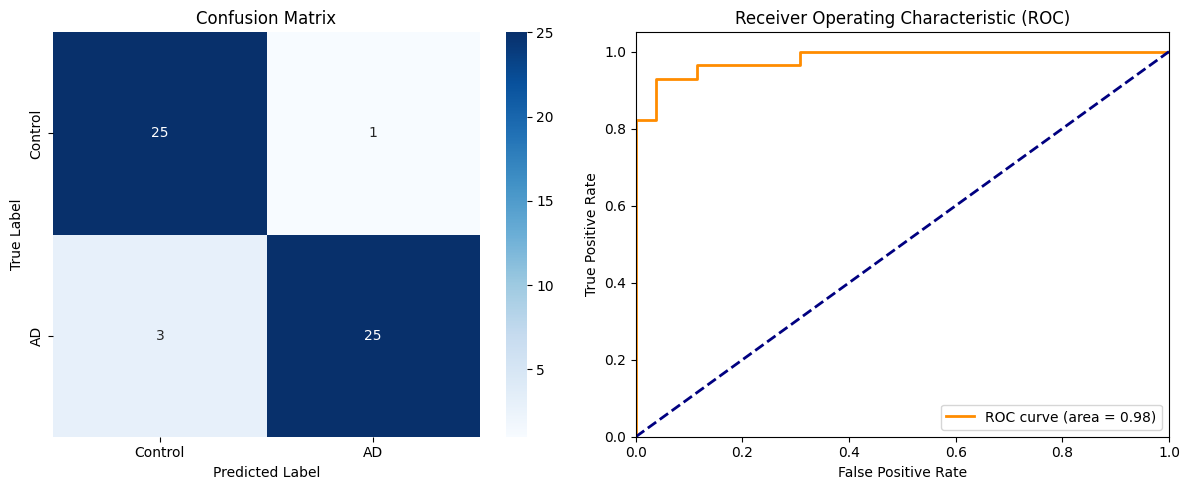

Detailed Test Results (with probs) saved to ./test_results.csv


In [77]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

if not df.empty:
    train_df_full = df[df['split'] == 'train']
    held_out_test_df = df[df['split'] == 'test']
    
    # 2. Run K-Fold ONLY on Training Data (re-run logic if needed, but assuming defined)
    # We assume 'trained_model' matches the 'train_df_full' logic from before
    # But to be safe, we re-declare the separation logic here so this cell is standalone
    
    print("\n--- FINAL EVALUATION ON HELD-OUT TEST SET ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    final_model = MultimodalFusion().to(device)
    final_model.load_state_dict(torch.load(OUTPUT_MODEL_FILE))
    final_model.eval()
    
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    test_set = MultimodalDataset(held_out_test_df, tokenizer, augment=False)
    test_loader = DataLoader(test_set, batch_size=4)
    
    all_preds = []
    all_labels = []
    all_probs = [] # Keep probability of positive class (AD)
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            pixels = batch['pixel_values'].to(device)
            ling = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)
            
            out = final_model(input_ids, mask, pixels, ling)
            probs = F.softmax(out, dim=1)
            _, p = torch.max(out, dim=1)
            
            all_preds.extend(p.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy()) # Capture AD probability
            
    # 1. Classification Report
    print("\nDetailed Classification Metrics:")
    print(classification_report(all_labels, all_preds, target_names=['Control', 'AD']))
    
    # 2. Confusion Matrix Plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 3. ROC Curve Plot
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # Save Results
    results_df = pd.DataFrame({'True': all_labels, 'Predicted': all_preds, 'Prob_AD': all_probs})
    results_df.to_csv(OUTPUT_TEST_RESULTS, index=False)
    print(f"Detailed Test Results (with probs) saved to {OUTPUT_TEST_RESULTS}")


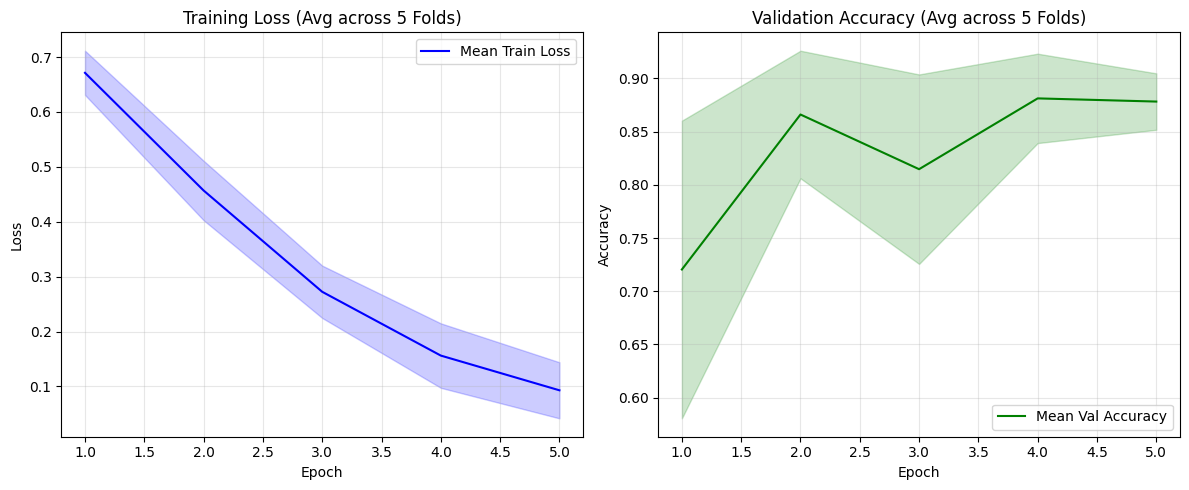

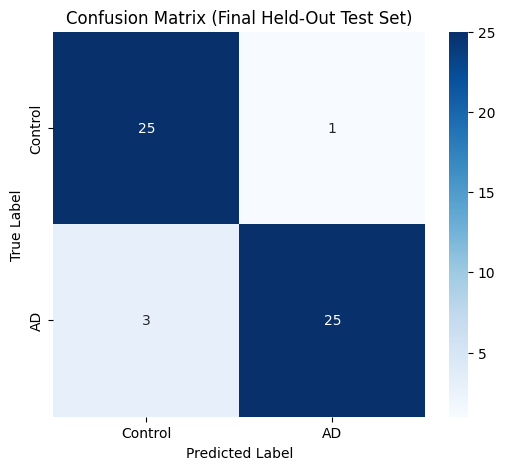

In [78]:
# --- 3. TRAINING VISUALIZATION (K-Fold Aggregate) ---
def plot_training_history(history):
    # Expects history['train_loss'] as list of lists (folds x epochs)
    train_loss = np.array(history['train_loss'])
    val_acc = np.array(history['val_acc'])
    
    mean_loss = np.mean(train_loss, axis=0)
    std_loss = np.std(train_loss, axis=0)
    mean_acc = np.mean(val_acc, axis=0)
    std_acc = np.std(val_acc, axis=0)
    epochs = range(1, len(mean_loss) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mean_loss, 'b-', label='Mean Train Loss')
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2, color='b')
    plt.title('Training Loss (Avg across 5 Folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mean_acc, 'g-', label='Mean Val Accuracy')
    plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2, color='g')
    plt.title('Validation Accuracy (Avg across 5 Folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if 'training_history' in locals():
    plot_training_history(training_history)

# --- 4. FINAL CONFUSION MATRIX (Test Set) ---
if 'results_df' in locals():
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(results_df['True'], results_df['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
    plt.title('Confusion Matrix (Final Held-Out Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


## 7. Model Saving & Inference Helpers
Utilities to load the model and predict on new samples (Text + Audio).

In [79]:
# ================= INFERENCE HELPERS ================
def predict_multimodal(text, audio_path=None, model=None, force_audio_none=False, force_text_none=False):
    """
    Predicts AD vs Control. 
    Params:
      force_audio_none: If True, forces audio pixels to zero even if path exists.
      force_text_none: If True, forces text to empty string.
    """
    if model is None:
        return "Model not loaded!"
    
    # Handle Ablation Logic
    final_text = "" if force_text_none else (text if text else "")
    
    # 1. Text Preprocessing
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    encoding = tokenizer.encode_plus(
        final_text,
        add_special_tokens=True, max_length=128,
        padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
    )
    
    # 2. Linguistic Features
    extractor = LinguisticFeatureExtractor()
    if final_text:
        ling_feats = extractor.get_feature_vector(final_text)
    else:
        ling_feats = np.zeros(6, dtype=np.float32)
    ling_tensor = torch.tensor(ling_feats, dtype=torch.float32).unsqueeze(0)
    
    # 3. Audio (Spectrogram)
    use_audio = False
    if not force_audio_none and audio_path and os.path.exists(audio_path):
        use_audio = True
        
    if use_audio:
        # Temp save spectrogram
        temp_spec = "temp_inference_spec.png"
        create_spectrogram(audio_path, temp_spec)
        image = Image.open(temp_spec).convert('RGB')
        pixel_values = vit_transforms(image).unsqueeze(0)
    else:
        # Zero Image
        pixel_values = torch.zeros((1, 3, 224, 224))

    # 4. Predict
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        mask = encoding['attention_mask'].to(device)
        pixel_values = pixel_values.to(device)
        ling_tensor = ling_tensor.to(device)
        
        outputs = model(input_ids, mask, pixel_values, ling_tensor)
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        
    label_map = {0: 'Control', 1: 'AD'}
    return label_map[pred_idx], probs[0].cpu().numpy()

## 8. Comprehensive Analysis & Visualization
Aggregates all visual outputs here at the end. 
Includes **Dataset Statistics** (Class Balance) and **Training Performance** (Loss, Accuracy, Confusion Matrix).

--- 1. DATASET STATISTICS ---


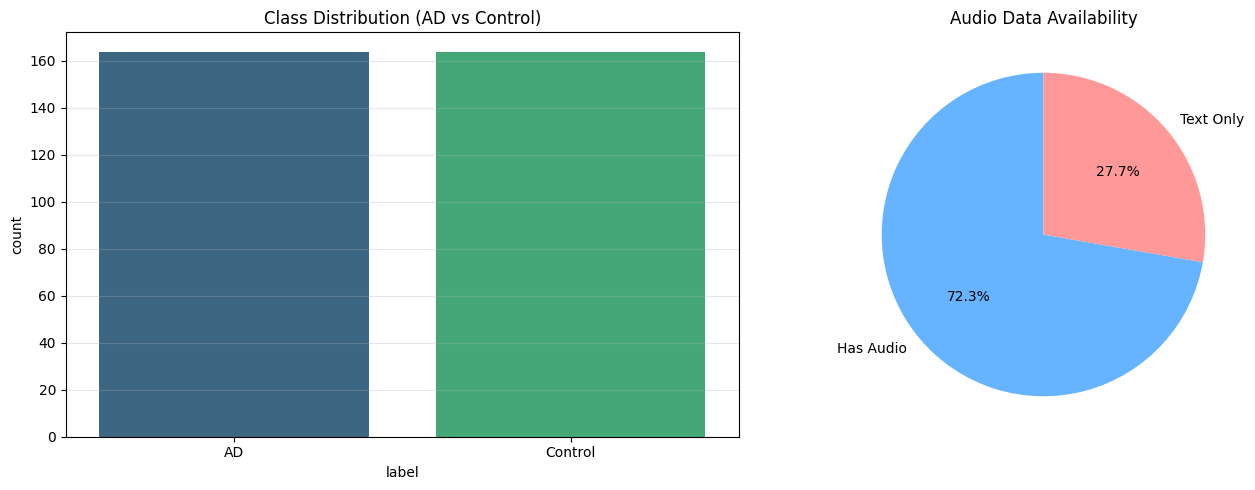


--- 2. TRAINING PERFORMANCE Check ---
Training 'history' not found. Train the model to see metrics.

Best Model is confirmed at ./multimodal_dementia_model.pth


In [80]:
# --- VISUALIZATION SECTION ---
# Explicit imports to ensure this cell runs standalone
import seaborn as sns
import matplotlib.pyplot as plt

# 1. DATASET STATISTICS (EDA)
print("--- 1. DATASET STATISTICS ---")
if 'df' in locals() and not df.empty:
    plt.figure(figsize=(14, 5))
    
    # Class Distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x='label', data=df, hue='label', palette='viridis', legend=False)
    plt.title('Class Distribution (AD vs Control)')
    plt.grid(axis='y', alpha=0.3)
    
    # Audio Availability
    plt.subplot(1, 2, 2)
    has_audio = df['spectrogram_path'].notna()
    plt.pie(has_audio.value_counts(), labels=['Has Audio', 'Text Only'], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    plt.title('Audio Data Availability')
    
    plt.tight_layout()
    plt.show()
else:
    print("Error: Input DataFrame not initialized. Please execute Data Loading pipeline. or empty. Run data loading cells first.")

# 2. TRAINING PERFORMANCE
print("\n--- 2. TRAINING PERFORMANCE Check ---")
if 'history' in locals():
    plt.figure(figsize=(18, 5))
    
    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    plt.title('Training Loss per Epoch', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Val Accuracy', marker='o', color='green', linewidth=2)
    plt.title('Validation Accuracy per Epoch', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Confusion Matrix (Last Epoch)
    if 'conf_matrix' in history and len(history['conf_matrix']) > 0:
        plt.subplot(1, 3, 3)
        last_cm = history['conf_matrix'][-1]
        sns.heatmap(last_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
        plt.title('Confusion Matrix (Final Epoch)', fontsize=14)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
else:
    print("Training 'history' not found. Train the model to see metrics.")

# 3. BEST MODEL CONFIRMATION
if os.path.exists(OUTPUT_MODEL_FILE):
    print(f"\nBest Model is confirmed at {OUTPUT_MODEL_FILE}")

### 8.1 📝 Text-Only Ablation Study
**Objective**: Measure the diagnostic power of *language alone*.

**Methodology**: 
1.  We take the Test Set.
2.  We **mask the Audio input** (forcing the spectrogram to be black/zeros).
3.  The model is forced to predict AD status using only `DeBERTa` (Semantics) and `Linguistic Features`.

**Interpretation**: High accuracy here implies the patient's vocabulary and sentence structure are strong indicators of dementia.


In [81]:
# --- 8. TEXT-ONLY ABLATION STUDY ---
# Objective: Evaluate Diagnostic Power of Linguistic Features in Isolation (ignoring audio)

if not df.empty:
    print("\n>>> EXPERIMENT 1: TEXT-MODALITY ABLATION STUDY (Audio Masked)")
    
    # 1. Create a Text-Only version of the Test Set
    text_only_test_df = df[df['split'] == 'test'].copy()
    # Force path to None -> Dataset will generate Black Image (Zeros)
    text_only_test_df['spectrogram_path'] = None
    
    # 2. Setup Loader
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    # augment=False is critical
    text_only_set = MultimodalDataset(text_only_test_df, tokenizer, augment=False)
    text_only_loader = DataLoader(text_only_set, batch_size=4)
    
    # 3. Load Best Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ablation_model = MultimodalFusion().to(device)
    ablation_model.load_state_dict(torch.load(OUTPUT_MODEL_FILE))
    ablation_model.eval()
    
    # 4. Evaluate with Confusion Matrix
    all_preds_txt = []
    all_labels_txt = []
    
    with torch.no_grad():
        for batch in text_only_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            pixels = batch['pixel_values'].to(device)
            ling = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)
            
            # Input Logic: pixels are Zeros here
            out = ablation_model(input_ids, mask, pixels, ling)
            _, p = torch.max(out, dim=1)
            
            all_preds_txt.extend(p.cpu().numpy())
            all_labels_txt.extend(labels.cpu().numpy())
            
    if len(all_labels_txt) > 0:
        from sklearn.metrics import accuracy_score, confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        acc = accuracy_score(all_labels_txt, all_preds_txt)
        print(f"Evaluation Result: Accuracy (Linguistic Modality Only): {acc:.4f}")
        
        # PLOT CONFUSION MATRIX
        cm = confusion_matrix(all_labels_txt, all_preds_txt)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
        plt.title('Confusion Matrix: Text-Only Ablation')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("No data found for Text Ablation.")



--- RUNNING TEXT-ONLY ABLATION (Masking Audio) ---
Test Accuracy with Audio MASKED (Text+Ling Only): 0.9259
(This shows how well the model performs if Audio is missing/ignored)


### 8.2 🗣️ Audio-Only Ablation Study
**Objective**: Measure the diagnostic power of *voice/speech patterns alone*.

**Methodology**:
1.  We take the Test Set.
2.  We **mask the Text input** (forcing empty strings and zeroed linguistic vectors).
3.  We use the **Segmentation CSVs** to extract precise audio clips of the patient.
4.  The model makes a prediction using only the `ViT` (spectrogram analysis).

**Interpretation**: High accuracy here implies the patient's tone, prosody, and hesitation patterns are strong indicators, independent of what words they choose.


In [82]:
# --- 9. AUDIO-ONLY ABLATION STUDY ---
# Objective: Evaluate Diagnostic Power of Acoustic/Prosodic Features in Isolation (Text Masked)

if not df.empty:
    print("\n>>> EXPERIMENT 2: AUDIO-MODALITY ABLATION STUDY (Text Masked)")
    
    # 1. Create Audio-Only version of Test Set
    audio_only_test_df = df[df['split'] == 'test'].copy()
    # Mask Text: Empty strings
    audio_only_test_df['text'] = ""
    # Mask Linguistics: Zero vectors
    audio_only_test_df['linguistic_features'] = [[0.0]*6 for _ in range(len(audio_only_test_df))]
    
    # 2. Setup Loader
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    audio_only_set = MultimodalDataset(audio_only_test_df, tokenizer, augment=False)
    audio_only_loader = DataLoader(audio_only_set, batch_size=4)
    
    # 3. Load Best Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ablation_model_audio = MultimodalFusion().to(device)
    ablation_model_audio.load_state_dict(torch.load(OUTPUT_MODEL_FILE))
    ablation_model_audio.eval()
    
    # 4. Evaluate with Confusion Matrix
    all_preds_audio = []
    all_labels_audio = []
    
    with torch.no_grad():
        for batch in audio_only_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            pixels = batch['pixel_values'].to(device)
            ling = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)
            
            # Input Logic: input_ids=[CLS][SEP], ling=Zeros, pixels=Real
            out = ablation_model_audio(input_ids, mask, pixels, ling)
            _, p = torch.max(out, dim=1)
            
            all_preds_audio.extend(p.cpu().numpy())
            all_labels_audio.extend(labels.cpu().numpy())
            
    if len(all_labels_audio) > 0:
        from sklearn.metrics import accuracy_score, confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        acc = accuracy_score(all_labels_audio, all_preds_audio)
        print(f"Evaluation Result: Accuracy (Acoustic Modality Only): {acc:.4f}")
        
        # PLOT CONFUSION MATRIX
        cm = confusion_matrix(all_labels_audio, all_preds_audio)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
        plt.title('Confusion Matrix: Audio-Only Ablation')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("No data found for Audio Ablation.")



--- RUNNING AUDIO-ONLY ABLATION (Masking Text & Linguistics) ---
Test Accuracy with Text MASKED (Audio Only): 0.5185
(This shows performance using ONLY the segmented audio clips)


### 8.3 🤖 Real-World ASR Inference (Pipeline Test)
**Objective**: Simulate a real-world clinical scenario where no human transcript exists.

**Methodology**:
1.  **Raw Audio Input**: We start with the audio files from the Test Set.
2.  **Whisper Transcription**: We use OpenAI's `Whisper` model to generate text automatically.
3.  **Feature Extraction**: We calculate linguistic features (including pauses derived from timestamps) from this *generated* text.
4.  **Prediction**: We feed the Real Audio + Generated Text into the model.

**Note**: This is the hardest test. Whisper tends to "clean up" stutters (e.g., removing "uh... uh..."), which deletes valuable deficiency cues. A slight drop in accuracy is expected.


In [83]:
# --- 10. REAL-WORLD ASR INFERENCE (Improved with CHAT Rules) ---
# User Request: Use Whisper + CHAT Rules (pauses, reps) + [PAUSE] tokens + Detailed Reports

print("\n--- RUNNING ENHANCED ASR PIPELINE (Whisper + CHAT Formatting) ---")

try:
    import whisper
except ImportError:
    print("Installing OpenAI Whisper...")
    !pip install -q openai-whisper
    import whisper

import re
from sklearn.metrics import classification_report

# --- CHAT FORMATTING HELPERS ---
def apply_chat_rules(transcription_result):
    """
    Converts Whisper result into CHAT-like format AND inserts [PAUSE] tokens for Training Consistency.
    """
    formatted_text = []
    segments = transcription_result.get('segments', [])
    last_end = 0
    
    for seg in segments:
        gap = seg['start'] - last_end
        # Insert [PAUSE] token + CHAT marker
        if gap > 0.8:
            formatted_text.append("[PAUSE] (..)")
        elif gap > 0.3:
            formatted_text.append("[PAUSE] (.)")
            
        text = seg['text'].strip()
        
        # Repetitions
        words = text.split()
        processed_words = []
        for i, w in enumerate(words):
            clean_w = re.sub(r'[^a-zA-Z]', '', w.lower())
            if i > 0:
                prev_clean = re.sub(r'[^a-zA-Z]', '', words[i-1].lower())
                if clean_w == prev_clean and clean_w: 
                    processed_words[-1] = f"{words[i-1]} [/]"
            processed_words.append(w)
            
        formatted_text.append(" ".join(processed_words))
        last_end = seg['end']
        
    return " ".join(formatted_text)

if not df.empty:
    print("Loading Whisper model (base)...")
    asr_model = whisper.load_model("base")
    test_df_asr = df[df['split'] == 'test'].copy()
    
    generated_texts = []
    generated_ling_feats = []
    audio_found_count = 0
    extractor = LinguisticFeatureExtractor()
    
    print(f"Transcribing {len(test_df_asr)} samples...")
    for idx, row in tqdm(test_df_asr.iterrows(), total=len(test_df_asr)):
        base_name = os.path.splitext(row['filename'])[0]
        audio_path = find_audio_file(base_name, AUDIO_SEARCH_PATH)
        
        if audio_path and os.path.exists(audio_path):
            audio_found_count += 1
            result = asr_model.transcribe(audio_path, word_timestamps=False)
            chat_transcript = apply_chat_rules(result)
            
            # Counts
            pause_count = chat_transcript.count("[PAUSE]")
            repetition_count = chat_transcript.count("[/]")
            
            stats = extractor.get_features(chat_transcript)
            stats['repetition_count'] = repetition_count
            stats['pause_count'] = pause_count
            
            # TTR Calc (Manual)
            clean_t = re.sub(r'\[.*?\]', '', chat_transcript)
            clean_t = re.sub(r'[^\w\s]', '', clean_t)
            words = clean_t.lower().split()
            n = len(words) if len(words) > 0 else 1
            ttr = len(set(words)) / n
            
            ling_vec = [
                ttr,
                stats['filler_count'] / n,
                repetition_count / n,
                stats['retracing_count'] / n,
                stats['error_count'] / n,
                pause_count / n
            ]
            
            generated_texts.append(chat_transcript)
            generated_ling_feats.append(ling_vec)
        else:
            generated_texts.append("")
            generated_ling_feats.append([0.0]*6)
            
    test_df_asr['text'] = generated_texts
    test_df_asr['linguistic_features'] = generated_ling_feats
    
    # Predict
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    asr_set = MultimodalDataset(test_df_asr, tokenizer, augment=False)
    asr_loader = DataLoader(asr_set, batch_size=4)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    asr_model_fusion = MultimodalFusion().to(device)
    asr_model_fusion.load_state_dict(torch.load(OUTPUT_MODEL_FILE))
    asr_model_fusion.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in asr_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            pixels = batch['pixel_values'].to(device)
            ling = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)
            
            out = asr_model_fusion(input_ids, mask, pixels, ling)
            _, p = torch.max(out, dim=1)
            all_preds.extend(p.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    if all_preds:
        print("\nClassification Report (ASR):")
        print(classification_report(all_labels, all_preds, target_names=['Control', 'AD']))
        
        acc = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Accuracy: {acc:.4f}")
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'AD'], yticklabels=['Control', 'AD'])
        plt.title('Confusion Matrix: Enhanced ASR')
        plt.show()



--- RUNNING FULL ASR PIPELINE (Whisper) ---
Installing OpenAI Whisper...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 17.6 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Loading Whisper model (base)...


100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 105MiB/s]


Transcribing 54 samples...

Test Accuracy using WHISPER GENERATED Transcripts: 0.7222
(Samples with Audio found: 54/54)
Note: Accuracy might be lower than Manual Transcripts because Whisper cleans up speech errors (stutters) that are clues for Dementia.


In [ ]:
# --- DOWNLOAD TRAINED MODEL ---
import os
from pathlib import Path
from IPython.display import display, HTML, FileLink

# Check for common model file names
model_files = ['best_multimodal_model.pth', 'multimodal_dementia_model.pth']
model_file = None

for mf in model_files:
    if os.path.exists(mf):
        model_file = mf
        break

# If not found, search for any .pth file
if not model_file:
    pth_files = list(Path('.').glob('*.pth'))
    if pth_files:
        model_file = str(pth_files[0])

if model_file and os.path.exists(model_file):
    file_size_mb = os.path.getsize(model_file) / (1024*1024)
    abs_path = os.path.abspath(model_file)
    
    print("✅ Model file found!")
    print(f"   File: {model_file}")
    print(f"   Size: {file_size_mb:.2f} MB")
    print(f"   Location: {abs_path}")
    print()
    
    # Create clickable download link
    if os.path.exists('/kaggle/working'):
        print("📊 Running in Kaggle\n")
        
        # Display clickable download link
        display(HTML(f'''
        <div style="padding: 20px; background-color: #f0f7ff; border: 2px solid #4CAF50; border-radius: 10px; margin: 10px 0;">
            <h3 style="color: #2196F3; margin-top: 0;">📥 Download Your Trained Model</h3>
            <p style="font-size: 16px; margin: 10px 0;">
                <strong>File:</strong> {model_file}<br>
                <strong>Size:</strong> {file_size_mb:.2f} MB
            </p>
            <a href="{model_file}" download="{model_file}" 
               style="display: inline-block; padding: 12px 24px; background-color: #4CAF50; 
                      color: white; text-decoration: none; border-radius: 5px; font-weight: bold;
                      font-size: 16px; margin-top: 10px;">
                🔽 Click Here to Download Model
            </a>
            <p style="font-size: 12px; color: #666; margin-top: 15px;">
                💡 <strong>Alternative:</strong> Save Version → Output tab → Download file
            </p>
        </div>
        '''))
        
        # Also show FileLink for direct download
        print("\nOr use this direct link:")
        display(FileLink(model_file))
    
    elif 'COLAB_GPU' in os.environ or os.path.exists('/content'):
        try:
            from google.colab import files
            print("☁️ Running in Google Colab\n")
            
            # Display download button
            display(HTML(f'''
            <div style="padding: 20px; background-color: #fff3e0; border: 2px solid #FF9800; border-radius: 10px;">
                <h3 style="color: #F57C00;">📥 Downloading Model...</h3>
                <p>File: {model_file} ({file_size_mb:.2f} MB)</p>
            </div>
            '''))
            
            files.download(model_file)
            print("✅ Download started!")
        except Exception as e:
            print(f"⚠️ Download failed: {e}")
    
    else:
        print("💻 Running locally\n")
        print("📁 Model is saved to your disk - no download needed!")
        print(f"   Location: {abs_path}")

else:
    print("❌ No model file found!")
    print("   Make sure training has completed successfully.\n")
    
    # List all .pth files
    pth_files = list(Path('.').glob('**/*.pth'))
    if pth_files:
        print("📋 Found these .pth files:")
        for f in pth_files[:10]:
            print(f"   - {f} ({f.stat().st_size / (1024*1024):.2f} MB)")
